結晶の乱れ具合 2


E = -0.5059552766002352


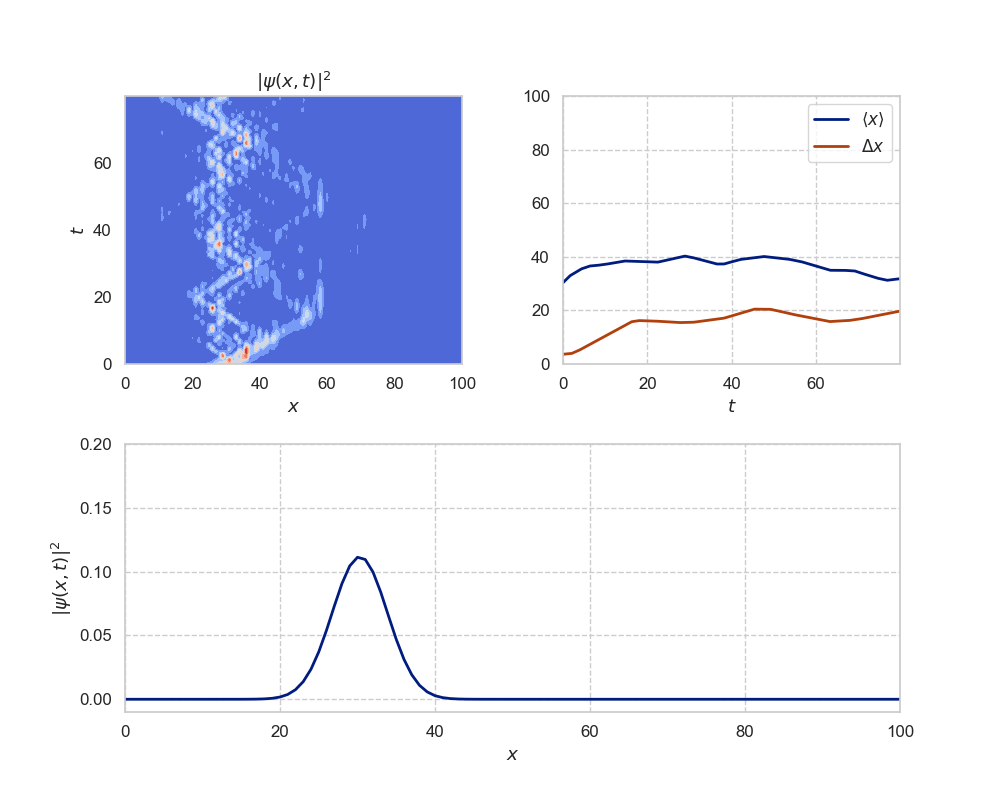

In [1]:
"""
量子ダイナミクスシミュレーション (1次元)
"""
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.animation as animation
import matplotlib.style as mplstyle


# ==================================================
def initialize_plot():
    """
    プロットの初期化
    """
    sns.set(
        "notebook",
        "whitegrid",
        "dark",
        font_scale=1.1,
        rc={"lines.linewidth": 2, "grid.linestyle": "--"},
    )
    mplstyle.use("fast")
    figure = plt.figure(figsize=(10, 8))

    # 2x2グリッド, 横隙間 0.3, 縦隙間 0.3
    grid = GridSpec(nrows=2, ncols=2, wspace=0.3, hspace=0.3)

    L = figure.add_subplot(grid[0, 0])  # 左上
    R = figure.add_subplot(grid[0, 1])  # 右上
    B = figure.add_subplot(grid[1, :])  # 下

    return figure, L, R, B


# ==================================================
def set_initial_wave_function(ham, psi0, N, Nt, Delta):
    """
    波動関数の初期化

    Args:
        ham (csr_matrix): ハミルトニアン (疎行列 N * N)
        psi0 (ndarray): 初期波動関数
        N (int): 行列サイズ
        Nt (int): 時間分割数
        Delta (float): Δ

    Returns:
        ndarray: 波動関数 (時刻0,1のみセット), psi[時刻, サイト] (Nt x N)
    """
    psi = np.zeros((Nt, N), dtype="complex")

    psi0 = psi0 / np.linalg.norm(psi0)
    psi[0] = psi0

    hpsi = -(1j * Delta) * ham.dot(psi0)
    psi1 = psi0 + hpsi - (0.5 * 1j * Delta) * ham.dot(hpsi)
    psi1 = psi1 / np.linalg.norm(psi1)
    psi[1] = psi1

    return psi


# ==================================================
def set_hamiltonian(N, periodic=True, impu=True):
    """
    ハミルトニアンのセット

    Args:
        N (int): 行列サイズ
        periodic (bool, optional): 周期境界条件 ?

    Returns:
        csr_matrix: ハミルトニアン行列 (疎行列 N * N)
    """
    t = 1.0
    v = 0.0
    data = [-t] * (N - 1) + [-t] * (N - 1) + [v] * N
    row = list(range(N - 1)) + list(range(1, N)) + list(range(N))
    col = list(range(1, N)) + list(range(N - 1)) + list(range(N))
    if periodic:
        data = data + [-t, -t]
        row = row + [0, N - 1]
        col = col + [N - 1, 0]

    if impu:                                #不純物のセット
        w = int(input('結晶の乱れ具合'))
        for i in range(N):
            np.random.seed(i)
            data[2 * N - 2 + i] = w * (float(np.random.rand(1)) - 0.5)

    ham = csr_matrix((data, (row, col)))
    ham.resize((N, N))

    return ham


# ==================================================
def time_evolution(ham, psi0, psi1, Delta):
    """
    時間発展

    Args:
        ham (csr_matrix): ハミルトニアン行列 (疎行列 N * N)
        psi0 (ndarray): 波動関数 (時刻 t-1)
        psi1 (ndarray): 波動関数 (時刻 t)
        Delta (float): Δ

    Returns:
        ndarray: 波動関数 (時刻 t+1)
    """
    psi2 = psi0 - (2.0 * 1j * Delta) * ham.dot(psi1)
    psi2 = psi2 / np.linalg.norm(psi2)

    return psi2


# ==================================================
def compute_position_av(xv, psi):
    """
    位置の期待値

    Args:
        xv (ndarray): x座標 (Nx)
        psi (ndarray): 波動関数 [時刻, サイト] (Nt x N)

    Returns:
        ndarray: 位置の期待値 (Nt)
    """
    x_av = np.array([sum(np.abs(psi[n]) ** 2 * xv) for n in range(psi.shape[0])])
    return x_av


# ==================================================
def compute_position_sd(xv, psi, x_av):
    """
    位置の標準偏差

    Args:
        xv (ndarray): x座標 (Nx)
        psi (ndarray): 波動関数 [時刻, サイト] (Nt x N)
        x_av (ndarray): 位置の期待値 (Nt)

    Returns:
        ndarray: 位置の標準偏差 (Nt)
    """
    x2_av = np.array([sum(np.abs(psi[n]) ** 2 * xv**2) for n in range(psi.shape[0])])
    x_sd = np.sqrt(x2_av - x_av**2)
    return x_sd


# ==================================================
def compute_energy_av(ham, psi):
    """
    エネルギー期待値

    Args:
        ham (csr_matrix): ハミルトニアン (疎行列 N * N)
        psi (ndarray): 波動関数 [時刻, サイト] (Nt x N)

    Returns:
        ndarray: エネルギー期待値 (Nt)
    """
    E_av = np.array(
        [sum(np.real(np.conjugate(psi[n]) * ham * psi[n])) for n in range(psi.shape[0])]
    )
    return E_av


# ==================================================
def compute_velocity_av(ham, psi):
    """
    速度の期待値

    Args:
        ham (csr_matrix): ハミルトニアン (疎行列 N * N)
        psi (ndarray): 波動関数 [時刻, サイト] (Nt x N)

    Returns:
        ndarray: エネルギー期待値 (Nt)
    """
    E_av = np.array(
        [sum(np.real(np.conjugate(psi[n]) * ham * psi[n])) for n in range(psi.shape[0])]
    )
    return E_av


# ==================================================
def plot_contour(xv, tv, psi, layer):
    """
    確率密度の描画

    Args:
        xv (ndarray): 位置座標
        tv (ndarray): 時刻
        psi (ndarray): 波動関数
        layer (plt): 描画レイヤー

    Returns:
        plt: プロットオブジェクト
    """
    xg, tg = np.meshgrid(xv, tv)
    ctr = layer.contourf(xg, tg, np.abs(psi) ** 2, cmap="coolwarm")
    layer.set_xlabel(r"$x$")
    layer.set_ylabel(r"$t$")
    layer.set_title(r"$|\psi(x,t)|^2$")

    return ctr


# ==================================================
def plot_x_av(xv, tv, psi, layer):
    """
    位置の期待値の描画

    Args:
        xv (ndarray): 位置座標
        tv (ndarray): 時刻
        psi (ndarray): 波動関数
        layer (plt): 描画レイヤー

    Returns:
        plt: プロットオブジェクト
    """
    x_av = compute_position_av(xv, psi)
    x_sd = compute_position_sd(xv, psi, x_av)
    layer.set_xlim(0, tv[-1])
    layer.set_ylim(0, xv[-1])
    layer.set_xlabel(r"$t$")
    p0 = layer.plot(tv, x_av, label=r"$\langle x \rangle$")
    p1 = layer.plot(tv, x_sd, label=r"$\Delta x$")
    layer.legend()

    return p0, p1


# ==================================================
def plot_animation(xv, tv, psi, figure, layer):
    """
    確率密度の時間変化の描画

    Args:
        xv (ndarray): 位置座標
        tv (ndarray): 時刻
        psi (ndarray): 波動関数
        figure (plt): 描画キャンバス
        layer (plt): 描画レイヤー

    Returns:
        plt: プロットオブジェクト
    """
    (line,) = layer.plot(xv, np.abs(psi[0]) ** 2)
    layer.set_xlim(0, xv[-1])
    layer.set_ylim(-0.01, 0.2)
    layer.set_xlabel(r"$x$")
    layer.set_ylabel(r"$|\psi(x,t)|^2$")

    # 更新するごとに呼ばれる関数
    def update(n, line):
        line.set_ydata(np.abs(psi[n]) ** 2)
        layer.set_title(f"t = {tv[n]: 3.02f}")
        return line

    # アニメーション (interval=各ステップ間の待ち時間, frames=繰り返しの上限)
    ani = animation.FuncAnimation(
        figure, update, interval=1, frames=psi.shape[0], fargs=(line,), repeat=False
    )

    return ani


# ==================================================
%matplotlib widget
def main():
    """
    メイン関数
    """
    Nx = 101  # 1次元サイト数
    Nt = 800  # 時刻の最大値

    Delta = 0.1  # Δ
    x0 = 0.3 * Nx  # 波束の初期中心
    sigma = 0.05 * Nx  # 波束の標準偏差
    k = 0.4 * np.pi  # 波数の範囲は [-π, π]だけ意味がある。

    xv = np.array(range(Nx))  # 位置座標のセット
    tv = np.array(range(Nt)) * Delta  # 時刻のセット

    ham = set_hamiltonian(Nx, periodic=False, impu=True)  # ハミルトニアンの生成

    psi0 = np.exp(-0.5 * ((xv - x0) / sigma) ** 2) * np.exp(1j * k * (xv - x0))  # 波束の準備

    psi = set_initial_wave_function(ham, psi0, Nx, Nt, Delta)  # 初期波動関数の準備

    for t in range(Nt - 2):  #  時間発展
        psi[t + 2] = time_evolution(ham, psi[t], psi[t + 1], Delta)

    E = compute_energy_av(ham, psi)  # エネルギー期待値
    print("E =", E[0])  # ハミルトニアンが時間変化しない場合、エネルギーは保存 (時刻によらず一定)

    figure, L, R, B = initialize_plot()
    ctr = plot_contour(xv, tv, psi, L)  # 確率密度の分布表示
    pl = plot_x_av(xv, tv, psi, R)  # 位置の期待値と標準偏差の時間依存性のプロット
    ani = plot_animation(xv, tv, psi, figure, B)  # 確率密度の時間発展アニメーション

    plt.show()


# ==================================================

main()